# Data Exploration Notebook

This notebook contains the code to produce a report the key insights extracted from theLook's company data on the following topics:
* sales trends
* product level performance
* regional performance
* website performance
* customer behaviour

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

from pathlib import Path
import os
from google.cloud import bigquery
client = bigquery.Client()

### Import Data from BigQuery

In [2]:
gcr_project_id = os.getenv('GCR_CLV_PROJECT_ID')
if not os.path.exists("data"):
    os.makedirs("data")

# Import order_items dataframe
QUERY  = f"""
SELECT
  *
FROM `ecommerce-data-project-444616.thelook_ecommerce.order_items`;
"""
df_order_items = client.query_and_wait(QUERY).to_dataframe()
df_order_items.to_csv("data/order_items.csv", index=False)

# Import orders dataframe
QUERY  = f"""
SELECT
  *
FROM `ecommerce-data-project-444616.thelook_ecommerce.orders`;
"""
df_orders = client.query_and_wait(QUERY).to_dataframe()
df_orders.to_csv("data/orders.csv", index=False)

# Import events dataframe
QUERY  = f"""
SELECT
  *
FROM `ecommerce-data-project-444616.thelook_ecommerce.events`;
"""
df_events = client.query_and_wait(QUERY).to_dataframe()
df_events.to_csv("data/events.csv", index=False)

# Import products dataframe
QUERY  = f"""
SELECT
  *
FROM `ecommerce-data-project-444616.thelook_ecommerce.products`;
"""
df_products = client.query_and_wait(QUERY).to_dataframe()
df_products.to_csv("data/products.csv", index=False)

# Import users dataframe
QUERY  = f"""
SELECT
  *
FROM `ecommerce-data-project-444616.thelook_ecommerce.users`;
"""
df_users = client.query_and_wait(QUERY).to_dataframe()
df_users.to_csv("data/users.csv", index=False)

# Import inventory_items dataframe
QUERY  = f"""
SELECT
  *
FROM `ecommerce-data-project-444616.thelook_ecommerce.inventory_items`;
"""
df_inventory_items = client.query_and_wait(QUERY).to_dataframe()
df_inventory_items.to_csv("data/inventory_items.csv", index=False)

# Import distribution_centers dataframe
QUERY  = f"""
SELECT
  *
FROM `ecommerce-data-project-444616.thelook_ecommerce.distribution_centers`;
"""
df_distribution_centers = client.query_and_wait(QUERY).to_dataframe()
df_distribution_centers.to_csv("data/distribution_centers.csv", index=False)

/Users/axel/ecommerce-project/env/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
/Users/axel/ecommerce-project/env/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
/Users/axel/ecommerce-project/env/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
/Users/axel/ecommerce-project/env/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
/Users/axel/ecommerce-project/env/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the 

### Import Data from Saved Files

In [3]:
df_orders = pd.read_csv('../data/orders.csv')
df_order_items = pd.read_csv('../data/order_items.csv')
df_users = pd.read_csv('../data/users.csv')
df_products = pd.read_csv('../data/products.csv')
df_events = pd.read_csv('../data/events.csv')
df_inventory_items = pd.read_csv('../data/inventory_items.csv')
df_distribution_centers = pd.read_csv('../data/distribution_centers.csv')

/var/folders/nj/x57yr4dd7cs205xl51ft7lqr0000gp/T/ipykernel_2795/3902602959.py:3: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_users = pd.read_csv('../data/users.csv')


### Analyse Core Sales Metrics

In [4]:
# Reformat datetime columns on order and order_items dataframes
df_orders['created_at'] = df_orders['created_at'].apply(lambda x : datetime.strptime(x.split(" ")[0], "%Y-%m-%d"))
df_order_items['created_at'] = df_order_items.drop(columns=["created_at"]).merge(df_orders[['order_id', 'created_at']], on='order_id', how='left')['created_at']


In [31]:
# Create dataframes containing only 2024 order data
df_order_items_24 = df_order_items[(df_order_items.created_at >= datetime(2024,1,1)) & (df_order_items.created_at <= datetime(2024,12,31))]
df_orders_24 = df_orders[(df_orders.created_at >= datetime(2024,1,1)) & (df_orders.created_at <= datetime(2024,12,31))]

# Create dataframes containing only 2023 order data
df_order_items_23 = df_order_items[(df_order_items.created_at >= datetime(2023,1,1)) & (df_order_items.created_at <= datetime(2023,12,31))]
df_orders_23 = df_orders[(df_orders.created_at >= datetime(2023,1,1)) & (df_orders.created_at <= datetime(2023,12,31))]

The total sales revenue in 2024 was 3857533.35
This is an increase of 1969808.34 (104.35%) compared to 2023's sales revenue which was 1887725.0114985704
The final two months of the year were responsible for 1180375.77 (30.60%) of this total revenue.


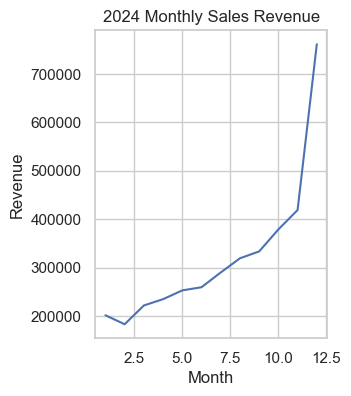

In [34]:
# Calculate Total Revenue from Sales
total_revenue = df_order_items_24[(df_order_items_24.status != 'Cancelled') & (df_order_items_24.returned_at.isna())]['sale_price'].sum()
total_revenue_23 = df_order_items_23[(df_order_items_23.status != 'Cancelled') & (df_order_items_23.returned_at.isna())]['sale_price'].sum()
print(f"The total sales revenue in 2024 was {total_revenue:.2f}")
print(f"This is an increase of {total_revenue - total_revenue_23:.2f} ({(total_revenue - total_revenue_23)/total_revenue_23*100:.2f}%) compared to 2023's sales revenue which was {total_revenue_23}")

# Plot 2024 monthly sales revenue
monthly_revenue = {}
for month in range(1,13):
    monthly_revenue[month] = df_order_items_24[(df_order_items_24.status != 'Cancelled') & (df_order_items_24.returned_at.isna())
                                               & (df_order_items_24.created_at.dt.month == month)]['sale_price'].sum()
print(f"The final two months of the year were responsible for {monthly_revenue[11] + monthly_revenue[12]:.2f} ({(monthly_revenue[11] + monthly_revenue[12])/total_revenue*100:.2f}%) of this total revenue.")
    
# Plot monthly sales revenue
fig = plt.figure(figsize=[3,4])
plt.plot(monthly_revenue.keys(), monthly_revenue.values())
plt.title("2024 Monthly Sales Revenue")
plt.xlabel("Month")
plt.ylabel("Revenue")

plt.show()

In 2024 there were 59712 orders placed.
However, 8985 (15.05%) of these orders  were cancelled, leaving 50727 fulfilled orders.
A further 6119 (12.06) of these fulfilled orders were later returned,meaning that only 44608 of the overall 59712 orders placed in 2024 (74.71%) actually generated revenue.


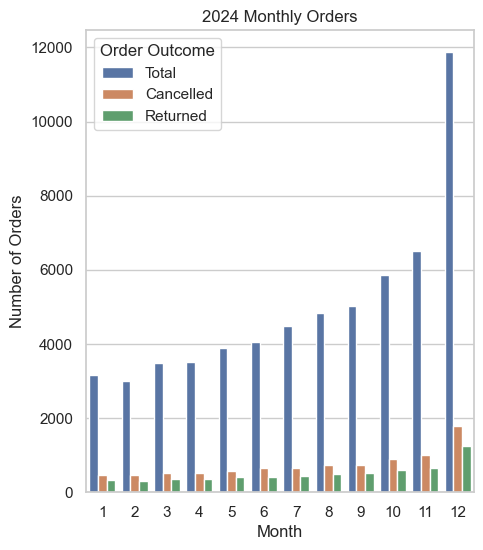

In [26]:
# Calculate total number of orders
total_orders = df_orders_24.order_id.nunique()
print(f"In 2024 there were {total_orders} orders placed.")

num_cancelled_orders = df_orders_24[df_orders_24.status == 'Cancelled'].order_id.nunique()
num_fulfilled_orders = df_orders_24[df_orders_24.status != 'Cancelled'].order_id.nunique()
num_returned_orders = df_orders_24[~df_orders_24.returned_at.isna()].order_id.nunique()
num_unreturned_orders = df_orders_24[(df_orders_24.returned_at.isna()) & (df_orders_24.status != 'Cancelled')].order_id.nunique()

print(f"However, {num_cancelled_orders} ({num_cancelled_orders/total_orders*100:.2f}%) of these orders were cancelled, leaving {num_fulfilled_orders} fulfilled orders.")
print(f"A further {num_returned_orders} ({num_returned_orders/num_fulfilled_orders*100:.2f}) of these fulfilled orders were later returned,\
meaning that only {num_unreturned_orders} of the overall {total_orders} orders placed in 2024 ({num_unreturned_orders/total_orders*100:.2f}%) actually generated revenue.")

monthly_orders = {}
monthly_cancelled_orders = {}
monthly_returned_orders = {}

for month in range(1,13):
    monthly_orders[month] = df_orders_24[(df_orders_24.created_at.dt.month == month)].order_id.nunique()
    monthly_cancelled_orders[month] = df_orders_24[(df_orders_24.status == 'Cancelled') & (df_orders_24.created_at.dt.month == month)].order_id.nunique()
    monthly_returned_orders[month] = df_orders_24[(~df_orders_24.returned_at.isna()) & (df_orders_24.created_at.dt.month == month)].order_id.nunique()

# Prepare the data in long format
data = {
    "Month": list(monthly_orders.keys()) * 3,
    "Order Type": (["Total"] * 12) + (["Cancelled"] * 12) + (["Returned"] * 12),
    "Count": list(monthly_orders.values()) + list(monthly_cancelled_orders.values()) + list(monthly_returned_orders.values())
}
df_plot = pd.DataFrame(data)

# Plot monthly total, cancelled & returned orders
fig, ax = plt.subplots(figsize=(5,6))

sns.set_theme(style="whitegrid")
sns.barplot(x="Month", y="Count", hue="Order Type", data=df_plot)

# Add plot labels
plt.title("2024 Monthly Orders")
plt.xlabel("Month")
plt.ylabel("Number of Orders")
plt.legend(title="Order Outcome")
plt.show()

In 2024 there were 73702 units sold.
However, 8930 (12.12%) of these units were returned, leaving 64772 units sold without return.


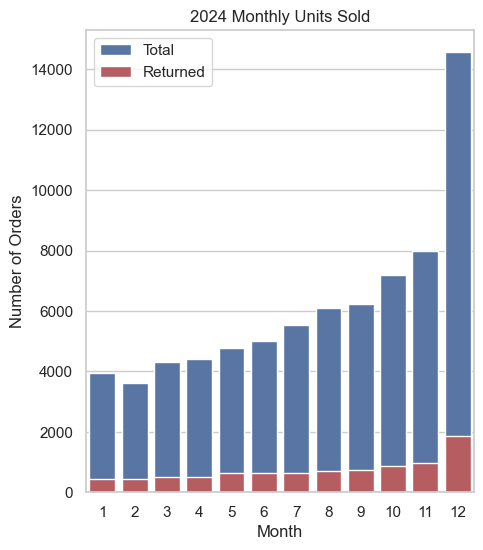

In [27]:
# Calculate total number of units sold
total_units_sold = df_order_items_24[df_order_items_24.status != 'Cancelled'].inventory_item_id.nunique()
print(f"In 2024 there were {total_units_sold} units sold.")

num_returned_units = df_order_items_24[~df_order_items_24.returned_at.isna()].inventory_item_id.nunique()
num_unreturned_units = df_order_items_24[(df_order_items_24.returned_at.isna()) & (df_order_items_24.status != 'Cancelled')].inventory_item_id.nunique()

print(f"However, {num_returned_units} ({num_returned_units/total_units_sold*100:.2f}%) of these units were returned, leaving {num_unreturned_units} units sold without return.")

monthly_units_sold = {}
monthly_units_returned = {}

for month in range(1,13):
    monthly_units_sold[month] = df_order_items_24[(df_order_items_24.status != 'Cancelled') &  (df_order_items_24.created_at.dt.month == month)].inventory_item_id.nunique()
    monthly_units_returned[month] = df_order_items_24[(df_order_items_24.status != 'Cancelled') &  (df_order_items_24.created_at.dt.month == month) & (~df_order_items_24.returned_at.isna())].inventory_item_id.nunique()

# Plot monthly units sold & returned
fig, ax = plt.subplots(figsize=(5,6))

sns.barplot(x=monthly_units_sold.keys(), y=monthly_units_sold.values(), data=monthly_units_sold,
            label="Total", color="b")
sns.barplot(x=monthly_units_returned.keys(), y=monthly_units_returned.values(), data=monthly_units_returned,
            label="Returned", color="r")

# Add plot labels
plt.title("2024 Monthly Units Sold")
plt.xlabel("Month")
plt.ylabel("Number of Orders")
plt.legend()
plt.show()

In [24]:
# Calculate Average Order Value
AOV = df_order_items_24.groupby(by='order_id').agg({'sale_price':'sum'}).sale_price.mean().item()
print(f"The average order value in 2024 was {AOV:.2f}")

AOV_true = df_order_items_24[(df_order_items_24.status != "Cancelled") & (df_order_items_24.returned_at.isna())].groupby(by='order_id').agg({'sale_price':'sum'}).sale_price.mean().item()
print(f"However, the average order value for orders that were not cancelled or returned was {AOV_true:.2f}")

The average order value in 2024 was 86.72
However, the average order value for orders that were not cancelled or returned was 86.48


### Analyse Product Performance

The highest selling product in 2024 was 'Unionbay Men's Donovan Yd Cargo Short' having sold 13 units.
Following on from this the products 'TapouT Men's Carver Thermal Fatigue Hoodie' and 'Sleeveless Low Cut Scoop Neck Fitted Sequins Evening Party Cocktail Dress S M L' both sold 12 units


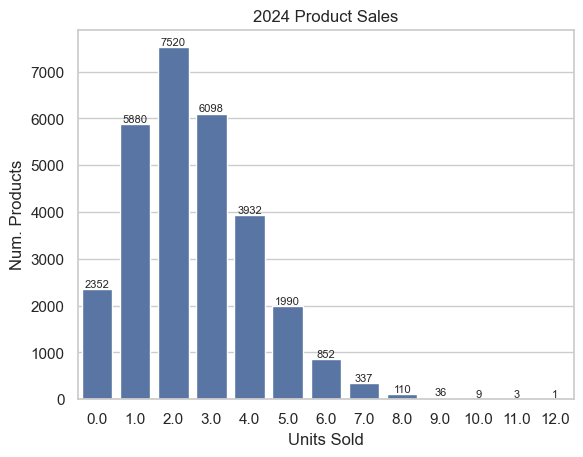

In [109]:
# Identify best-selling products by units sold
product_units_sold = df_order_items_24[df_order_items_24.status != 'Cancelled'].product_id.value_counts()
product_units_sold = pd.merge(df_products, product_units_sold, how = 'left', left_on='id', right_on='product_id').fillna({"count":0}).rename(columns={'count':'units_sold'}).sort_values(by='units_sold', ascending=False)
product_units_sold[['name','units_sold']].head(50)
print(f"The highest selling product in 2024 was 'Unionbay Men's Donovan Yd Cargo Short' having sold 13 units.")
print(f"Following on from this the products 'TapouT Men's Carver Thermal Fatigue Hoodie' and 'Sleeveless Low Cut Scoop Neck Fitted Sequins Evening Party Cocktail Dress S M L' both sold 12 units")

# Get product sales counts
sales_value_counts = product_units_sold['units_sold'].value_counts().reset_index()
sales_value_counts.columns = ['Units Sold', 'Num. Products']

# Plot product sales counts
ax = sns.barplot(x='Units Sold', y='Num. Products', data=sales_value_counts)
ax.bar_label(ax.containers[0], fontsize=8)

plt.title('2024 Product Sales')
plt.xlabel('Units Sold')
plt.ylabel('Num. Products')
plt.show()

In [92]:
# Identify best selling products by revenue generated
product_revenue = df_order_items_24[(df_order_items_24.status != 'Cancelled')].groupby('product_id').agg({'sale_price':'sum'})
product_revenue = pd.merge(df_products, product_revenue, how='left', left_on='id', right_on='product_id').fillna({"sale_price":0}).rename(columns={'sale_price':'sales_revenue'}).sort_values(by='sales_revenue', ascending=False)
product_revenue[['name','sales_revenue']].head(10)

,name,sales_revenue
10978,The North Face Apex Bionic Soft Shell Jacket -...,7224.000000
10981,The North Face Nuptse 2 Jacket Deep Water Blue...,4515.000000
21438,Regency New York Men's Smoking Jacket Bartholo...,3999.500122
11938,Nobis Men's Cartel Jacket,3750.000000
19029,NIKE WOMEN'S PRO COMPRESSION SPORTS BRA *Outst...,3612.000000
10977,The North Face Apex Bionic Jacket - Men's,3612.000000
27810,Mens Nike AirJordan Varsity Hoodie Jacket Grey...,3612.000000
12844,adidas Women's adiFIT Slim Pant,3612.000000
216,ASCIS Cushion Low Socks (Pack of 3),3612.000000
27519,Diesel Men's Lagnum Leather Jacket,3588.000000


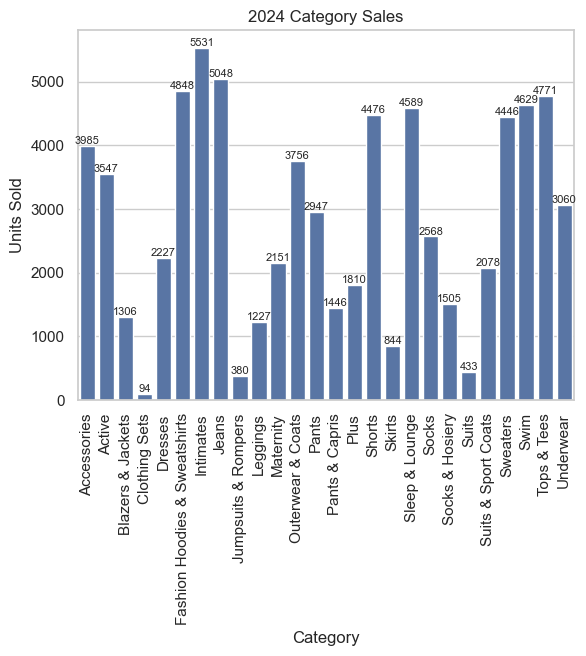

In [129]:
# Analyse sales performance across different product categories
cat_units_sold = product_units_sold.groupby('category').agg({'units_sold':'sum'})

# Plot category units sold
ax = sns.barplot(x='category', y='units_sold', data=cat_units_sold)
ax.bar_label(ax.containers[0], fontsize=8, )

plt.title('2024 Category Sales')
plt.xlabel('Category')
plt.xticks(rotation=90)
plt.ylabel('Units Sold')
plt.show()

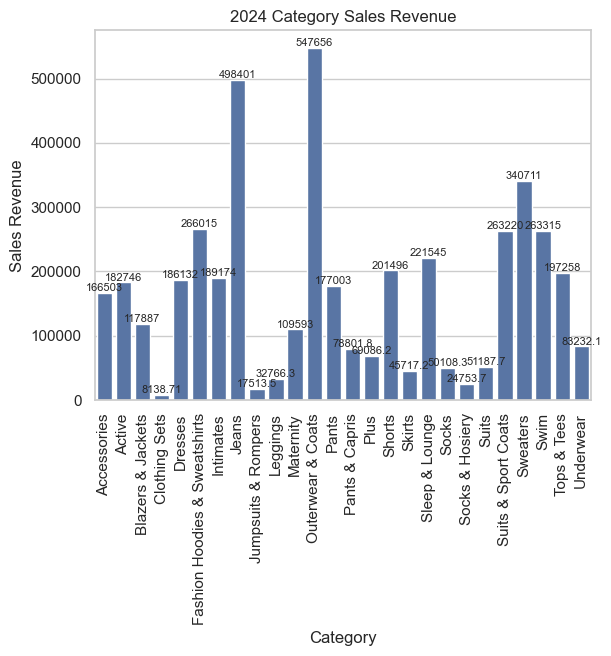

In [128]:
cat_revenue = product_revenue.groupby('category').agg({'sales_revenue':'sum'})

# Plot category revenue
ax = sns.barplot(x='category', y='sales_revenue', data=cat_revenue)
ax.bar_label(ax.containers[0], fontsize=8)

plt.title('2024 Category Sales Revenue')
plt.xlabel('Category')
plt.xticks(rotation=90)
plt.ylabel('Sales Revenue')
plt.show()

### Analyse Customer Behaviour

In [145]:
# Reformat 'created_at' column to be datetime
#df_users['created_at'] = df_users['created_at'].apply(lambda x : datetime.strptime(x.split(" ")[0], "%Y-%m-%d"))
new_users = df_users[df_users.created_at >= datetime(2024,1,1)].id.to_list()
returning_users = df_users[df_users.created_at <= datetime(2023,12,31)].id.to_list()

In [148]:
# Calculate Percentage of revenue from new vs. returning customers
new_user_revenue = df_order_items_24[(df_order_items_24.user_id.isin(new_users)) & ((df_order_items_24.status != 'Cancelled')) & (df_order_items_24.returned_at.isna())].sale_price.sum().item()
returning_user_revenue = df_order_items_24[(df_order_items_24.user_id.isin(returning_users)) & ((df_order_items_24.status != 'Cancelled')) & (df_order_items_24.returned_at.isna())].sale_price.sum().item()

# Calculate percentage of orders placed by new vs returning customers
new_user_units_sold = df_order_items_24[(df_order_items_24.user_id.isin(new_users)) & ((df_order_items_24.status != 'Cancelled'))].inventory_item_id.nunique()
returning_user_units_sold = df_order_items_24[(df_order_items_24.user_id.isin(returning_users)) & ((df_order_items_24.status != 'Cancelled'))].inventory_item_id.nunique()

print(f"New users accounted for {new_user_revenue:.2f} ({new_user_revenue/(new_user_revenue + returning_user_revenue)*100:.2f}%) of the total sales revenue in 2024,")
print(f"and {new_user_units_sold} ({new_user_units_sold/(new_user_units_sold+returning_user_units_sold)*100:.2f}%) of the units sold.")

print(f"In contrast, returning users accounted for {returning_user_revenue:.2f} ({returning_user_revenue/(new_user_revenue + returning_user_revenue)*100:.2f}%) of the total sales revenue,")
print(f"and {returning_user_units_sold} ({returning_user_units_sold/(new_user_units_sold+returning_user_units_sold)*100:.2f}%) of the units sold.")


New users accounted for 1514237.63 (39.25%) of the total sales revenue in 2024,
and 29170 (39.58%) of the units sold.
In contrast, returning users accounted for 2343295.72 (60.75%) of the total sales revenue,
and 44532 (60.42%) of the units sold.


In [149]:
# Import CLTV calculation data
gcr_project_id = os.getenv('GCR_CLV_PROJECT_ID')
QUERY  = f"""
WITH order_values AS (
    SELECT 
      order_id,
      SUM(sale_price) as order_value
    FROM `{gcr_project_id}.thelook_ecommerce.order_items`
    GROUP BY order_id
    ORDER BY order_id
)
SELECT 
  orders.order_id,
  orders.user_id,
  users.first_name,
  users.last_name,
  users.email,
  orders.created_at,
  orders.status,
  order_values.order_value
FROM `{gcr_project_id}.thelook_ecommerce.orders` AS orders
    LEFT JOIN `{gcr_project_id}.thelook_ecommerce.users` AS users ON orders.user_id = users.id
    LEFT JOIN order_values on orders.order_id = order_values.order_id
ORDER BY orders.order_id;
"""

df_ltv = client.query_and_wait(QUERY).to_dataframe()

/Users/axel/ecommerce-project/env/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [156]:
# Get Customer Summary Data : Frequency, Recency, Monetary Value
import lifetimes
df_summary  = lifetimes.utils.summary_data_from_transaction_data(df_ltv, 'user_id', 'created_at',
                                                                 freq='D', include_first_transaction = False)
df_summary['current_ltv'] = df_ltv.groupby('user_id')[['order_value']].sum()
df_summary.sort_values(by="current_ltv", ascending=False).head(5)

/Users/axel/ecommerce-project/env/lib/python3.11/site-packages/lifetimes/utils.py:287: UserWarning: Converting to Period representation will drop timezone information.
  pd.to_datetime(transactions[datetime_col].max(), format=datetime_format).to_period(freq).to_timestamp()
/Users/axel/ecommerce-project/env/lib/python3.11/site-packages/lifetimes/utils.py:203: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  transactions = transactions.set_index(datetime_col).to_period(freq).to_timestamp()


,frequency,recency,T,current_ltv
user_id,,,,
78473,3.0,75.0,324.0,2260.879997
92289,2.0,263.0,1081.0,2143.979996
21613,3.0,788.0,1000.0,1664.679999
74810,3.0,602.0,918.0,1652.449999
37188,3.0,1616.0,1774.0,1606.160000


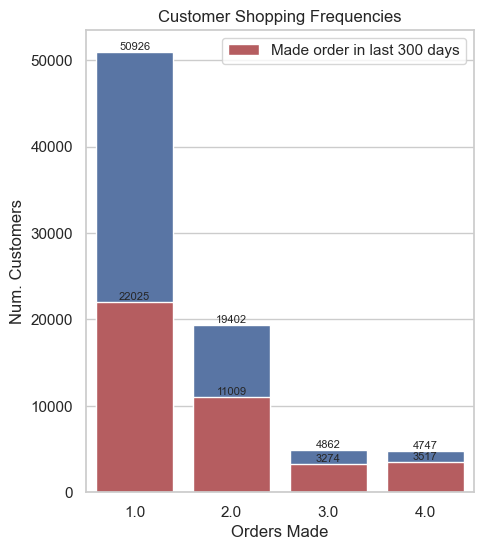

In [183]:
# Plot customer frequencies
fig, ax = plt.subplots(figsize=(5,6))

# Get shopper frequency value counts
freq_value_counts = (df_summary['frequency']+1).value_counts().reset_index()
freq_value_counts.columns = ['Frequency', 'Num. Customers']

ax = sns.barplot(x='Frequency', y='Num. Customers', data=freq_value_counts)
ax.bar_label(ax.containers[0], fontsize=8)

# Get alive shopper frequency value counts
alive_freq_value_counts = (df_summary[df_summary['T'] - df_summary.recency < 300]['frequency']+1).value_counts().reset_index()
alive_freq_value_counts.columns = ['Frequency', 'Num. Customers']

ax = sns.barplot(x='Frequency', y='Num. Customers', data=alive_freq_value_counts, color="r", label="Made order in last 300 days")
ax.bar_label(ax.containers[1], fontsize=8)

plt.title('Customer Shopping Frequencies')
plt.xlabel('Orders Made')
plt.ylabel('Num. Customers')
plt.legend()
plt.show()

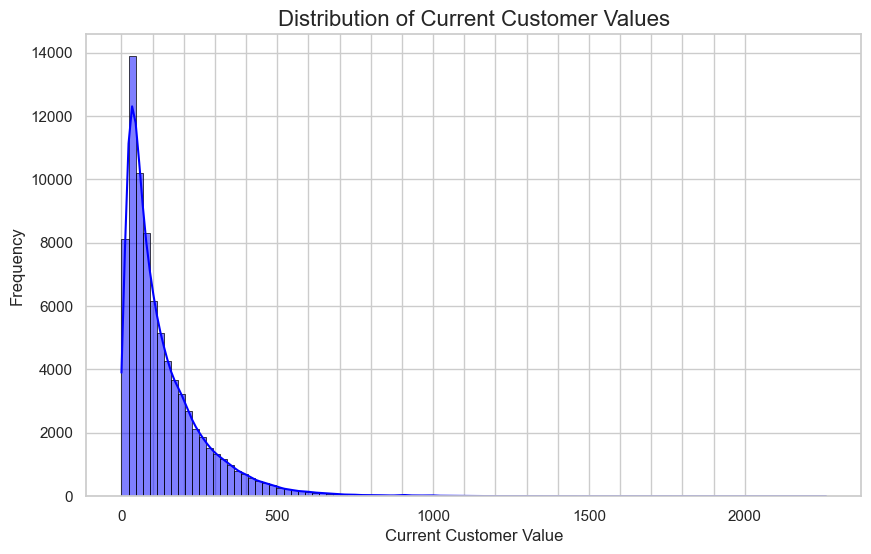

In [202]:
# Plot distribution of current LTV's
plt.figure(figsize=(10, 6))
sns.histplot(df_summary['current_ltv'], kde=True, bins=100, color='blue', edgecolor='black')

plt.title('Distribution of Current Customer Values', fontsize=16)
tick_labels = [str(int(tick)) if tick % 500 == 0 else '' for tick in np.arange(0, 2001, 100)]
plt.xticks(ticks=np.arange(0, 2001, 100), labels=tick_labels)
plt.xlabel('Current Customer Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.show()

### Analyze Regional Performance

In [223]:
# Calculate regional revenue
region_revenue = pd.merge(df_order_items_24, df_users[['id', 'country']], how='left', left_on='user_id', right_on='id').drop(columns=['id_x','id_y'])

regional_metrics = pd.merge(region_revenue.groupby('country', as_index=False).agg({'sale_price':'sum'}).rename({'sale_price':'total_revenue'}),
                            region_revenue.groupby(['country','order_id'],as_index=False).agg({'sale_price':'sum'}).groupby('country').agg({'sale_price':'mean'}).rename(columns={'sale_price':'AOV'}),
                            on='country')
regional_metrics.sort_values(by='sale_price', ascending=False)

,country,sale_price,AOV
3,China,1.751316e+06,86.258956
13,United States,1.172203e+06,86.413815
2,Brasil,7.582663e+05,87.438454
10,South Korea,2.691528e+05,87.104473
6,France,2.431552e+05,86.011744
12,United Kingdom,2.403878e+05,85.944866
11,Spain,2.095873e+05,88.808165
7,Germany,2.052487e+05,85.094830
8,Japan,1.299351e+05,88.874897
0,Australia,1.226509e+05,90.383876


### Analyze Website Performance